In [1]:
import numpy as np
import pandas as pd
import ast
import statsmodels.api as sm
import sqlite3
import datetime

# next command ensures that plots appear inside the notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # also improves the look of plots
sns.set()
plt.rcParams['figure.figsize'] = 10, 5  # default hor./vert. size of plots, in inches
plt.rcParams['lines.markeredgewidth'] = 1  # to fix issue with seaborn box plots; needed after import seaborn

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
ba_tweets = pd.read_csv('Full datasets/ba_tweets.csv', encoding = 'unicode_escape')
ba_tweets.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quoted_status_id_str,retweet_count,text,user.id,user.id_str,entities,quoted_status
0,6050,Tue May 31 10:00:09 +0000 2016,0.0,low,7.375844e+17,7.375844e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Where in #Europe brings back happy holiday #me...,18332190.0,18332190.0,"{ ""hashtags"" : [ { ""text"" : ""Europe"", ""indices...",NaN
1,14878,Tue May 31 10:30:08 +0000 2016,0.0,low,7.375920e+17,7.375920e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Summer time is beach time! Travel to some of t...,18332190.0,18332190.0,"{ ""hashtags"" : [ ], ""user_mentions"" : [ ], ""...",NaN
2,16578,Wed Jun 01 10:00:09 +0000 2016,0.0,low,7.379468e+17,7.379468e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Miles of golden sand just a stone's throw from...,18332190.0,18332190.0,"{ ""hashtags"" : [ { ""text"" : ""Palma"", ""indices""...",NaN
3,17470,Wed Jun 01 10:30:07 +0000 2016,0.0,low,7.379544e+17,7.379544e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Gear up for #Wimbledon! How many tennis balls ...,18332190.0,18332190.0,"{ ""hashtags"" : [ { ""text"" : ""Wimbledon"", ""indi...",NaN
4,25752,Fri Jun 03 10:00:06 +0000 2016,0.0,low,7.386716e+17,7.386716e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Planning a trip to #Rome? Here's how to get th...,18332190.0,18332190.0,"{ ""hashtags"" : [ { ""text"" : ""Rome"", ""indices"" ...",NaN


In [3]:
#Creating British Airways matrices
#Convert the created_at data to timestamp objects
ba_tweets['created_at'] = pd.to_datetime(ba_tweets['created_at'])

#Extracting the seperate timestamp objects and adding them to new columns in the ba_tweets dataframe
ba_tweets["weekday"] = ba_tweets["created_at"].dt.weekday
ba_tweets['hour'] = ba_tweets['created_at'].dt.hour
ba_tweets["month"] = ba_tweets["created_at"].dt.month
ba_tweets['year'] = ba_tweets['created_at'].dt.year
ba_tweets['day'] = ba_tweets['created_at'].dt.day

#Drop Nas in the day and month rows (these will be plotted later in the heatmap)
ba_tweets = ba_tweets.dropna(subset=['day', 'month'])

#Because month 4 is missing, we add one empty row with month = 4 so that it will appear in the heatmap
empty_df = pd.DataFrame({'Unnamed: 0':['NaN'], 'created_at':['NaN'], 'favorite_count':['NaN'], 'filter_level':['NaN'],
                        'id':['NaN'], 'id_str':['NaN'], 'in_reply_to_screen_name':['NaN'], 'in_reply_to_status_id':['NaN'],
                        'in_reply_to_status_id_str':['NaN'], 'in_reply_to_user_id':['NaN'], 'in_reply_to_user_id_str':['NaN'],
                        'lang':['NaN'], 'quoted_status_id_str':['NaN'], 'retweet_count':['NaN'], 'text':['NaN'],
                        'user.id':['NaN'], 'user.id_str':['NaN'], 'entities':['NaN'], 'quoted_status':['NaN'], 'weekday':['NaN'],
                        'hour':['NaN'], 'month':[4], 'year':['NaN'], 'day':[1]})
ba_tweets = pd.concat([ba_tweets, empty_df])

In [4]:
ba_tweets_grouped = ba_tweets.groupby(['month', 'day']).count().reset_index()
ba_tweets_matrix = ba_tweets_grouped.pivot('month', 'day', 'text')
ba_tweets_matrix = ba_tweets_matrix.fillna(0)
ba_tweets_matrix

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,234.0,756.0,410.0,626.0,772.0
2,625.0,632.0,577.0,508.0,606.0,534.0,513.0,650.0,537.0,591.0,...,582.0,679.0,581.0,635.0,503.0,620.0,585.0,0.0,0.0,0.0
3,786.0,538.0,604.0,562.0,454.0,700.0,833.0,656.0,697.0,660.0,...,607.0,539.0,536.0,598.0,499.0,735.0,669.0,560.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
6,5.0,2.0,4.0,3.0,0.0,3.0,5.0,3.0,2.0,3.0,...,2.0,2.0,0.0,0.0,0.0,4.0,2.0,0.0,1.0,0.0
7,5.0,2.0,0.0,3.0,4.0,585.0,943.0,895.0,703.0,757.0,...,777.0,681.0,832.0,951.0,943.0,792.0,1075.0,895.0,621.0,839.0
8,985.0,1073.0,966.0,903.0,914.0,463.0,945.0,900.0,942.0,694.0,...,485.0,1554.0,705.0,970.0,978.0,767.0,645.0,828.0,677.0,962.0
9,781.0,921.0,909.0,667.0,1054.0,1509.0,1148.0,873.0,816.0,805.0,...,297.0,784.0,475.0,651.0,440.0,627.0,476.0,901.0,753.0,0.0


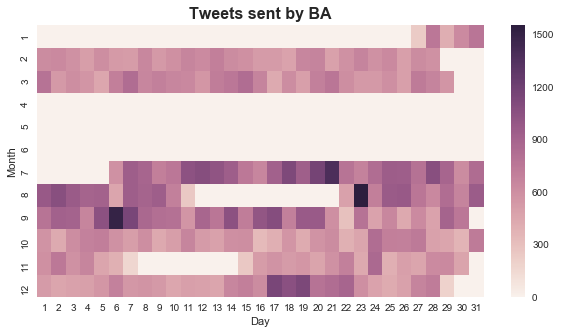

In [5]:
#Creating a heatmap with tweets sent by BA
ax_1 = sns.heatmap(ba_tweets_matrix)
ax_1.set_title('Tweets sent by BA', size=16, weight='bold')
ax_1.set_ylabel('Month')
ax_1.set_xlabel('Day');

In [6]:
ax_1.get_figure().savefig('Heatmap tweets BA.png')

In [24]:
to_ba_tweets = pd.read_csv('Full datasets/to_ba.csv')
to_ba_tweets.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quoted_status_id_str,retweet_count,text,user.id,user.id_str,entities,quoted_status,twee
0,43,Mon May 30 14:33:40 +0000 2016,0.0,low,7.372909e+17,7.37290886736937e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Why can @British_Airways not run flights from ...,7.018670e+17,7.018670e+17,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to British_Airways
1,158,Mon May 30 14:37:17 +0000 2016,0.0,low,7.372918e+17,7.372917959318774e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,"Oh, great. 2 hour delay for my @British_Airway...",5.347142e+06,5.347142e+06,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to British_Airways
2,186,Mon May 30 14:38:08 +0000 2016,0.0,low,7.372920e+17,7.372920117834588e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Literally had it with your bullshit @British_A...,1.812127e+08,1.812127e+08,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to British_Airways
3,313,Tue May 31 07:41:06 +0000 2016,0.0,low,7.375494e+17,7.375494482013921e+17,British_Airways,NaN,NaN,18332190.0,18332190.0,en,NaN,0.0,@British_Airways why bother with priority boar...,1.383981e+07,1.383981e+07,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to British_Airways
4,429,Tue May 31 07:48:26 +0000 2016,0.0,low,7.375513e+17,7.375512964173046e+17,British_Airways,NaN,NaN,18332190.0,18332190.0,en,NaN,0.0,"@British_Airways Hi, so you seem to have kicke...",1.574900e+07,1.574900e+07,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to British_Airways


In [25]:
#Creating British Airways matrices
to_ba_tweets['created_at'] = pd.to_datetime(to_ba_tweets['created_at'], errors='coerce')

to_ba_tweets['weekday'] = to_ba_tweets["created_at"].dt.weekday
to_ba_tweets['hour'] = to_ba_tweets['created_at'].dt.hour
to_ba_tweets['month'] = to_ba_tweets["created_at"].dt.month
to_ba_tweets['year'] = to_ba_tweets['created_at'].dt.year
to_ba_tweets['day'] = to_ba_tweets['created_at'].dt.day

to_ba_tweets = to_ba_tweets.dropna(subset=['day', 'month'])

#Because month 4 is missing, we add one empty row with month = 4 so that it will appear in the heatmap
empty_df3 = pd.DataFrame({'Unnamed: 0':['NaN'], 'created_at':['NaN'], 'favorite_count':['NaN'], 'filter_level':['NaN'],
                        'id':['NaN'], 'id_str':['NaN'], 'in_reply_to_screen_name':['NaN'], 'in_reply_to_status_id':['NaN'],
                        'in_reply_to_status_id_str':['NaN'], 'in_reply_to_user_id':['NaN'], 'in_reply_to_user_id_str':['NaN'],
                        'lang':['NaN'], 'quoted_status_id_str':['NaN'], 'retweet_count':['NaN'], 'text':['NaN'],
                        'user.id':['NaN'], 'user.id_str':['NaN'], 'entities':['NaN'], 'quoted_status':['NaN'], 'weekday':['NaN'],
                        'hour':['NaN'], 'month':[4], 'year':['NaN'], 'day':[1]})
to_ba_tweets = pd.concat([to_ba_tweets, empty_df3])

to_ba_tweets = to_ba_tweets.astype({'day':int, 'month':int})

In [26]:
to_ba_tweets_grouped = to_ba_tweets.groupby(['month', 'day']).count().reset_index()
to_ba_tweets_matrix = to_ba_tweets_grouped.pivot('month', 'day', 'text')
to_ba_tweets_matrix = to_ba_tweets_matrix.fillna(0)
to_ba_tweets_matrix

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,618.0,865.0,788.0,781.0,1121.0
2,853.0,913.0,838.0,780.0,971.0,793.0,768.0,888.0,884.0,1129.0,...,944.0,984.0,849.0,775.0,790.0,854.0,829.0,0.0,0.0,0.0
3,875.0,836.0,793.0,737.0,734.0,1056.0,1055.0,958.0,1014.0,798.0,...,821.0,771.0,763.0,804.0,758.0,1029.0,988.0,674.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,170.0
6,339.0,462.0,416.0,450.0,290.0,373.0,349.0,453.0,375.0,400.0,...,428.0,656.0,712.0,542.0,31.0,353.0,409.0,348.0,495.0,0.0
7,496.0,372.0,506.0,475.0,544.0,1064.0,1222.0,1268.0,960.0,1085.0,...,1493.0,1000.0,1324.0,1173.0,1085.0,1185.0,1399.0,1310.0,885.0,1038.0
8,1549.0,1503.0,1327.0,1127.0,1220.0,844.0,1194.0,1240.0,1147.0,1112.0,...,896.0,3139.0,1312.0,1416.0,1334.0,988.0,943.0,1032.0,1156.0,1215.0
9,1374.0,1230.0,1029.0,1233.0,1331.0,2286.0,1293.0,1234.0,1189.0,958.0,...,314.0,933.0,723.0,742.0,867.0,884.0,791.0,2918.0,1624.0,0.0


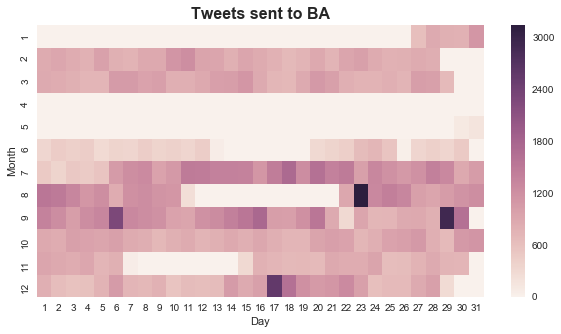

In [27]:
#Creating a heatmap with tweets sent to BA
ax_3 = sns.heatmap(to_ba_tweets_matrix)
ax_3.set_title('Tweets sent to BA', size=16, weight='bold')
ax_3.set_ylabel('Month')
ax_3.set_xlabel('Day');

In [7]:
ax_3.get_figure().savefig('Heatmap tweets to BA.png')

In [7]:
klm_tweets = pd.read_csv('Full datasets/klm_tweets.csv')
klm_tweets.head()

,Unnamed: 0,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quoted_status_id_str,retweet_count,text,user.id,user.id_str,entities,quoted_status,twee
0,1102,Tue May 31 08:28:49 +0000 2016,0.0,low,7.375615e+17,7.375615e+17,BIKEZONENL,7.375558e+17,7.375558e+17,9.106998e+07,9.106998e+07,nl,NaN,0.0,"@BIKEZONENL Dat is vervelend, excuses voor het...",5.637714e+07,5.637714e+07,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,by klm
1,1125,Tue May 31 08:30:11 +0000 2016,0.0,low,7.375618e+17,7.375618e+17,NaN,NaN,NaN,NaN,NaN,de,NaN,0.0,Königlicher Besuch in Southampton! #KLM https:...,3.761224e+07,3.761224e+07,"{ ""hashtags"" : [ { ""text"" : ""KLM"", ""indices"" :...",NaN,by klm
2,1458,Mon May 30 10:04:26 +0000 2016,0.0,low,7.372231e+17,7.372231e+17,atckuoh91,7.371945e+17,7.371945e+17,2.882527e+09,2.882527e+09,en,NaN,0.0,"@atckuoh91 Indeed Alan, you are entitled to 2 ...",5.637714e+07,5.637714e+07,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,by klm
3,2052,Mon May 30 10:30:02 +0000 2016,0.0,low,7.372296e+17,7.372296e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,Inspiring destinations and the latest KLM news...,1.940153e+07,1.940153e+07,"{ ""hashtags"" : [ { ""text"" : ""KLM"", ""indices"" :...",NaN,by klm
4,2524,Tue May 31 19:47:28 +0000 2016,0.0,low,7.377322e+17,7.377322e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,KLM's first prototype! #1 @ Downingtown STEM A...,7.243772e+17,7.243772e+17,"{ ""hashtags"" : [ ], ""user_mentions"" : [ ], ""...",NaN,by klm


In [8]:
klm_tweets['created_at'] = pd.to_datetime(klm_tweets['created_at'])

klm_tweets["weekday"] = klm_tweets["created_at"].dt.weekday
klm_tweets['hour'] = klm_tweets['created_at'].dt.hour
klm_tweets["month"] = klm_tweets["created_at"].dt.month
klm_tweets['year'] = klm_tweets['created_at'].dt.year
klm_tweets['day'] = klm_tweets['created_at'].dt.day

klm_tweets = klm_tweets.dropna(subset=['day', 'month'])

#Because month 4 is missing, we add one empty row with month = 4 so that it will appear in the heatmap
empty_df2 = pd.DataFrame({'Unnamed: 0':['NaN'], 'created_at':['NaN'], 'favorite_count':['NaN'], 'filter_level':['NaN'],
                        'id':['NaN'], 'id_str':['NaN'], 'in_reply_to_screen_name':['NaN'], 'in_reply_to_status_id':['NaN'],
                        'in_reply_to_status_id_str':['NaN'], 'in_reply_to_user_id':['NaN'], 'in_reply_to_user_id_str':['NaN'],
                        'lang':['NaN'], 'quoted_status_id_str':['NaN'], 'retweet_count':['NaN'], 'text':['NaN'],
                        'user.id':['NaN'], 'user.id_str':['NaN'], 'entities':['NaN'], 'quoted_status':['NaN'], 'weekday':['NaN'],
                        'hour':['NaN'], 'month':[4], 'year':['NaN'], 'day':[1]})
klm_tweets = pd.concat([klm_tweets, empty_df2])

In [9]:
klm_tweets_grouped = klm_tweets.groupby(['month', 'day']).count().reset_index()

klm_tweets_matrix = klm_tweets_grouped.pivot('month','day','text')
klm_tweets_matrix = klm_tweets_matrix.fillna(0)
klm_tweets_matrix

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,140.0,270.0,308.0,265.0,277.0
2,442.0,329.0,357.0,314.0,339.0,272.0,360.0,366.0,241.0,340.0,...,470.0,1028.0,658.0,332.0,368.0,321.0,320.0,0.0,0.0,0.0
3,340.0,303.0,356.0,245.0,237.0,317.0,266.0,264.0,294.0,366.0,...,237.0,234.0,214.0,207.0,258.0,235.0,252.0,221.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,5.0
6,21.0,21.0,24.0,13.0,7.0,19.0,30.0,22.0,25.0,23.0,...,32.0,12.0,14.0,11.0,1.0,10.0,19.0,16.0,15.0,0.0
7,13.0,7.0,12.0,28.0,16.0,452.0,519.0,481.0,466.0,345.0,...,470.0,439.0,352.0,427.0,462.0,527.0,510.0,534.0,723.0,704.0
8,828.0,847.0,763.0,625.0,571.0,564.0,530.0,517.0,648.0,606.0,...,303.0,610.0,546.0,496.0,650.0,519.0,363.0,590.0,529.0,584.0
9,662.0,583.0,571.0,425.0,515.0,489.0,529.0,575.0,467.0,408.0,...,178.0,470.0,406.0,395.0,419.0,434.0,451.0,479.0,395.0,0.0


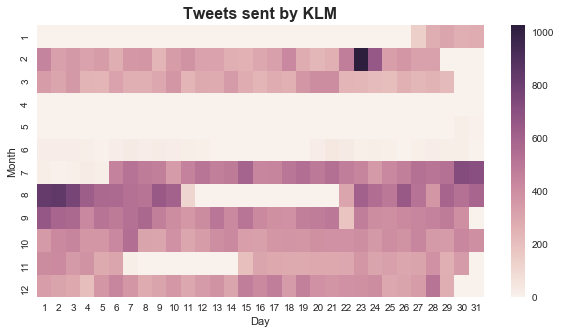

In [10]:
#Creating a heatmap with tweets sent by BA
ax_2 = sns.heatmap(klm_tweets_matrix)
ax_2.set_title('Tweets sent by KLM', size=16, weight='bold')
ax_2.set_ylabel('Month')
ax_2.set_xlabel('Day');

In [11]:
ax_2.get_figure().savefig('Heatmap tweets KLM.png')

In [2]:
to_klm_tweets = pd.read_csv('Full datasets/to_klm.csv')
to_klm_tweets.head()

,Unnamed: 0,created_at,favorite_count,filter_level,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,lang,quoted_status_id_str,retweet_count,text,user.id,user.id_str,entities,quoted_status,twee
0,103,Mon May 30 14:35:53 +0000 2016,0.0,low,7.372914e+17,7.372914457621996e+17,KLM,NaN,NaN,56377143.0,56377143.0,en,NaN,0.0,@klm how do I change my frequent flyer card on...,4.958449e+07,4.958449e+07,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to klm
1,115,Mon May 30 14:36:10 +0000 2016,0.0,low,7.372915e+17,7.372915168179036e+17,KLM,NaN,NaN,56377143.0,56377143.0,en,NaN,0.0,@KLM - why is flight KL 1286 cancelled? What r...,1.074405e+09,1.074405e+09,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to klm
2,139,Mon May 30 14:36:48 +0000 2016,0.0,low,7.372917e+17,7.37291677883347e+17,NaN,NaN,NaN,NaN,NaN,en,NaN,0.0,A ball ache of a journey for many travelling t...,3.392277e+09,3.392277e+09,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to klm
3,145,Mon May 30 14:36:56 +0000 2016,0.0,low,7.372917e+17,7.372917100410675e+17,KLM,7.372757e+17,7.372757e+17,56377143.0,56377143.0,nl,NaN,0.0,@KLM bedankt weer voor de service.Just landed ...,2.549641e+08,2.549641e+08,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to klm
4,269,Mon May 30 14:40:47 +0000 2016,0.0,low,7.372927e+17,7.372926788288225e+17,KLM,7.371919e+17,7.371919e+17,56377143.0,56377143.0,nl,NaN,0.0,@KLM Als de 747 niet meer rendabel is waarom i...,3.467321e+09,3.467321e+09,"{ ""hashtags"" : [ ], ""user_mentions"" : [ { ""sc...",NaN,to klm


In [4]:
to_klm_tweets['created_at'] = pd.to_datetime(to_klm_tweets['created_at'], errors='coerce')

to_klm_tweets["weekday"] = to_klm_tweets["created_at"].dt.weekday
to_klm_tweets['hour'] = to_klm_tweets['created_at'].dt.hour
to_klm_tweets["month"] = to_klm_tweets["created_at"].dt.month
to_klm_tweets['year'] = to_klm_tweets['created_at'].dt.year
to_klm_tweets['day'] = to_klm_tweets['created_at'].dt.day

to_klm_tweets = to_klm_tweets.dropna(subset=['day', 'month'])

#Because month 4 is missing, we add one empty row with month = 4 so that it will appear in the heatmap
empty_df4 = pd.DataFrame({'Unnamed: 0':['NaN'], 'created_at':['NaN'], 'favorite_count':['NaN'], 'filter_level':['NaN'],
                        'id':['NaN'], 'id_str':['NaN'], 'in_reply_to_screen_name':['NaN'], 'in_reply_to_status_id':['NaN'],
                        'in_reply_to_status_id_str':['NaN'], 'in_reply_to_user_id':['NaN'], 'in_reply_to_user_id_str':['NaN'],
                        'lang':['NaN'], 'quoted_status_id_str':['NaN'], 'retweet_count':['NaN'], 'text':['NaN'],
                        'user.id':['NaN'], 'user.id_str':['NaN'], 'entities':['NaN'], 'quoted_status':['NaN'], 'weekday':['NaN'],
                        'hour':['NaN'], 'month':[4], 'year':['NaN'], 'day':[1]})
to_klm_tweets = pd.concat([to_klm_tweets, empty_df4])

to_klm_tweets = to_klm_tweets.astype({'day':int, 'month':int})

In [5]:
to_klm_tweets_grouped = to_klm_tweets.groupby(['month', 'day']).count().reset_index()

to_klm_tweets_matrix = to_klm_tweets_grouped.pivot('month','day','text')
to_klm_tweets_matrix = to_klm_tweets_matrix.fillna(0)
to_klm_tweets_matrix

day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
month,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,177.0,405.0,376.0,296.0,315.0
2,452.0,351.0,426.0,368.0,337.0,360.0,367.0,411.0,302.0,376.0,...,973.0,1209.0,720.0,444.0,383.0,364.0,344.0,0.0,0.0,0.0
3,358.0,303.0,392.0,282.0,251.0,346.0,280.0,282.0,311.0,408.0,...,244.0,239.0,281.0,234.0,286.0,249.0,257.0,274.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.0,57.0
6,202.0,171.0,160.0,149.0,176.0,135.0,233.0,137.0,165.0,227.0,...,241.0,209.0,294.0,195.0,12.0,151.0,204.0,179.0,170.0,0.0
7,120.0,260.0,337.0,303.0,226.0,541.0,499.0,446.0,484.0,356.0,...,462.0,508.0,356.0,398.0,462.0,531.0,420.0,507.0,756.0,770.0
8,966.0,890.0,834.0,656.0,651.0,531.0,503.0,452.0,578.0,569.0,...,319.0,742.0,576.0,511.0,607.0,515.0,388.0,540.0,522.0,605.0
9,539.0,545.0,587.0,422.0,426.0,476.0,554.0,529.0,422.0,389.0,...,150.0,485.0,381.0,322.0,467.0,386.0,433.0,446.0,406.0,0.0


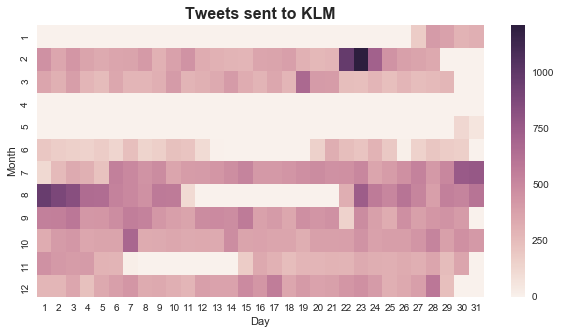

In [6]:
#Creating a heatmap with tweets sent to KLM
ax_4 = sns.heatmap(to_klm_tweets_matrix)
ax_4.set_title('Tweets sent to KLM', size=16, weight='bold')
ax_4.set_ylabel('Month')
ax_4.set_xlabel('Day');

In [7]:
ax_4.get_figure().savefig('Heatmap tweets to KLM.png')

In [18]:
#Code for creating the comparison heatmaps: tweets by KLM/BA
ba_tweets['airline'] = 'BA'
klm_tweets['airline'] = 'KLM'

df_klm_ba = pd.concat([klm_tweets, ba_tweets])
tweets_grouped = df_klm_ba.groupby(['month','airline']).count().reset_index()

tweets_matrix = tweets_grouped.pivot('month', 'airline','text')
tweets_matrix = tweets_matrix.fillna(0)
tweets_matrix

airline,BA,KLM
month,,
1,2798,1260
2,16497,10199
3,18423,8222
4,1,1
5,2,19
6,47,420
7,23350,12936
8,17606,11804
9,24216,13683


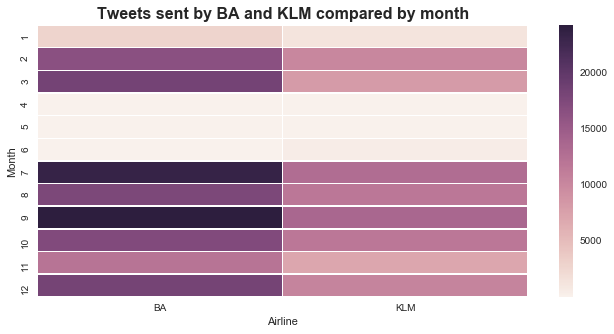

In [29]:
fig1, ax_5 = plt.subplots(figsize=(11, 5))
sns.heatmap(tweets_matrix, linewidths=.5)
ax_5.set_title('Tweets sent by BA and KLM compared by month', size=16, weight='bold')
ax_5.set_xlabel('Airline')
ax_5.set_ylabel('Month');

In [30]:
ax_5.get_figure().savefig('Heatmap BA KLM compared.png')

In [28]:
#Heatmap comparing tweets sent to KLM/BA
to_ba_tweets['airline'] = 'BA'
to_klm_tweets['airline'] = 'KLM'

df_to_klm_ba = pd.concat([to_klm_tweets, to_ba_tweets])
tweets_grouped2 = df_to_klm_ba.groupby(['month','airline']).count().reset_index()

tweets_matrix2 = tweets_grouped2.pivot('month', 'airline','text')
tweets_matrix2 = tweets_matrix2.fillna(0)
tweets_matrix2

airline,BA,KLM
month,,
1,4173,1569
2,24383,11791
3,25592,9343
4,1,1
5,270,181
6,9402,4208
7,35545,13644
8,25946,12068
9,36686,13237


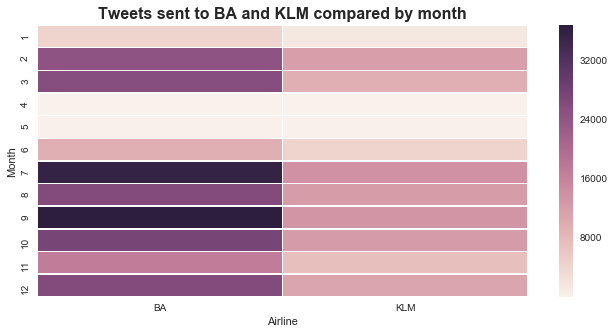

In [31]:
fig2, ax_6 = plt.subplots(figsize=(11, 5))
sns.heatmap(tweets_matrix2, linewidths=.5)
ax_6.set_title('Tweets sent to BA and KLM compared by month', size=16, weight='bold')
ax_6.set_xlabel('Airline')
ax_6.set_ylabel('Month');

In [32]:
ax_6.get_figure().savefig('Heatmap to BA KLM compared.png')